In [1]:
# Copyright 2019 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# Visualization of the YAMNet audio event classification model.
# See https://github.com/tensorflow/models/tree/master/research/audioset/yamnet/
#
# This notebook can be run in Google Colab at https://colab.research.google.com
# by either downloading this ipynb and uploading it, or by looking up the
# notebook directly on GitHub in Colab's "Open notebook" dialog.

In [10]:
!pip3 install dataclasses numpy resampy soundfile

  Using cached tensorflow-2.3.1-cp36-cp36m-macosx_10_9_x86_64.whl (165.1 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Processing /Users/sdimi/Library/Caches/pip/wheels/93/2a/eb/e58dbcbc963549ee4f065ff80a59f274cc7210b6eab962acdc/termcolor-1.1.0-py3-none-any.whl
Processing /Users/sdimi/Library/Caches/pip/wheels/32/42/7f/23cae9ff6ef66798d00dc5d659088e57dbba01566f6c60db63/wrapt-1.12.1-cp36-cp36m-macosx_10_9_x86_64.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.10.11
ERROR: Cannot uninstall 'wrapt'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
You should consider upgrading via the '/Users/sdimi/anaconda3/bin/python -m pip install --upgrade pip' command.


In [12]:
!pip3 install tensorflow  --ignore-installed

  Using cached tensorflow-2.3.1-cp36-cp36m-macosx_10_9_x86_64.whl (165.1 MB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached absl_py-0.11.0-py3-none-any.whl (127 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard-2.4.0-py3-none-any.whl (10.6 MB)
  Using cached protobuf-3.14.0-cp36-cp36m-macosx_10_9_x86_64.whl (1.0 MB)
Processing /Users/sdimi/Library/Caches/pip/wheels/93/2a/eb/e58dbcbc963549ee4f065ff80a59f274cc7210b6eab962acdc/termcolor-1.1.0-py3-none-any.whl
  Using cached h5py-2.10.0-cp36-cp36m-macosx_10_6_intel.whl (3.0 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 15.1 MB 22.0 MB/s eta 0:00:01
Processing /Users/sdimi/Library/Caches/pip/wheels/32/42/7f/23cae9ff6ef66798d00dc5d659088e57dbba01566f6c60db63/wrapt-1.12.1-cp36-cp36m-macosx_10_9_x86_64.whl
  Using cached grpcio-1.34.0-cp36-cp3

In [8]:
# Install required packages.
!pip install soundfile
!git clone https://github.com/tensorflow/models.git
%cd models/research/audioset/yamnet

# Download YAMNet data
!curl -O https://storage.googleapis.com/audioset/yamnet.h5

# Download audio for testing
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

!ls -l

You should consider upgrading via the '/Users/sdimi/anaconda3/bin/python -m pip install --upgrade pip' command.
Cloning into 'models'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 47907 (delta 21), reused 31 (delta 2), pack-reused 47853
Receiving objects: 100% (47907/47907), 552.00 MiB | 13.12 MiB/s, done.
Resolving deltas: 100% (32989/32989), done.
/Users/sdimi/models/research/audioset/yamnet/models/research/audioset/yamnet
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.5M  100 14.5M    0     0  14.5M      0  0:00:01  0:00:01 --:--:-- 10.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  153k  100  153k    0     0   153k      0  0:00:01 --:--:--  0:00:0

In [13]:
# Imports.
import numpy as np
import soundfile as sf

import matplotlib.pyplot as plt

import params as yamnet_params
import yamnet as yamnet_model
import tensorflow as tf

In [104]:
# Read in the audio.
wav_file_name = 'cough_distorted.wav' # %cd models/research/audioset/yamnet
wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / 32768.0

In [105]:
# The graph is designed for a sampling rate of 16 kHz, but higher rates should work too.
# We also generate scores at a 10 Hz frame rate.
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)
print("Sample rate =", params.sample_rate)

Sample rate = 16000


In [106]:
# Set up the YAMNet model.
class_names = yamnet_model.class_names('yamnet_class_map.csv')
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('yamnet.h5')

In [107]:
waveform.shape

(88960, 2)

In [101]:
#our audio is stereo (2 features) hence we have to avg the channels
waveform = waveform.sum(axis=1) / 2 

#or pick one channel (we have an issue with distorted only-left or right android files)
#waveform= waveform[:,0] #
waveform.shape

(88960,)

In [109]:
# Run the model.
scores, embeddings, spectrogram = yamnet(waveform)
scores = scores.numpy()
spectrogram = spectrogram.numpy()

In [110]:
scores

array([[1.4184713e-03, 1.2762190e-12, 6.6874103e-11, ..., 1.0166338e-18,
        1.6437704e-14, 5.1100077e-26],
       [2.4080873e-02, 7.9594553e-03, 4.2399764e-04, ..., 1.7866492e-04,
        9.4006624e-05, 1.8952902e-11],
       [3.3726990e-03, 2.2301078e-04, 1.2110440e-05, ..., 2.4416480e-08,
        4.3314238e-08, 6.9706265e-20],
       ...,
       [1.0806474e-01, 8.2525611e-03, 7.7641606e-03, ..., 3.3407956e-02,
        1.8055320e-02, 2.7462840e-04],
       [5.6042701e-02, 5.7731867e-03, 2.7639568e-03, ..., 9.0470910e-03,
        9.8344684e-04, 4.9626460e-06],
       [1.3677483e-11, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

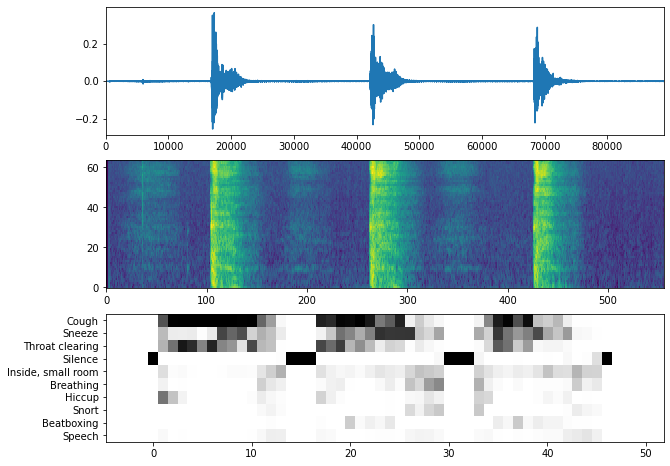

In [111]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the patch_window_seconds (0.96s) context window to align with spectrogram.
patch_padding = (params.patch_window_seconds / 2) / params.patch_hop_seconds
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))


In [96]:
class_names[top_class_indices]

array(['Explosion', 'Sound effect', 'Burst, pop', 'Gunshot, gunfire',
       'Sneeze', 'Whack, thwack', 'Cough', 'Clang', 'Ding', 'Speech'],
      dtype='<U40')